In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from commpy.utilities  import signal_power, upsample
from commpy.modulation import QAMModem
from utils.dsp import firFilter, pulseShape, lowPassFIR, edc, fourthPowerFOE, dbp, cpr
from utils.models import mzm, linFiberCh, iqm, ssfm, edfa, phaseNoise, coherentReceiver, manakov_ssf
from utils.tx import simpleWDMTx
from utils.core import parameters

from scipy import signal
import scipy.constants as const

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

# Simulation of coherent WDM systems

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coherent-WDM-system" data-toc-modified-id="Coherent-WDM-system-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coherent WDM system</a></span><ul class="toc-item"><li><span><a href="#Transmitter" data-toc-modified-id="Transmitter-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Transmitter</a></span></li></ul></li></ul></div>

## Coherent WDM system

### Transmitter

In [5]:
help(simpleWDMTx)

Help on function simpleWDMTx in module utils.tx:

simpleWDMTx(param)
    Simple WDM transmitter
    
    Generates a complex baseband waveform representing a WDM signal with arbitrary number of carriers
    
    :param.M: QAM order [default: 16]
    :param.Rs: carrier baud rate [baud][default: 32e9]
    :param.SpS: samples per symbol [default: 16]
    :param.Nbits: total number of bits per carrier [default: 60000]
    :param.pulse: pulse shape ['nrz', 'rrc'][default: 'rrc']
    :param.Ntaps: number of coefficients of the rrc filter [default: 4096]
    :param.alphaRRC: rolloff do rrc filter [default: 0.01]
    :param.Pch_dBm: launched power per WDM channel [dBm][default:-3 dBm]
    :param.Nch: number of WDM channels [default: 5]
    :param.Fc: central frequency of the WDM spectrum [Hz][default: 193.1e12 Hz]
    :param.freqSpac: frequency spacing of the WDM grid [Hz][default: 40e9 Hz]
    :param.Nmodes: number of polarization modes [default: 1]



In [6]:
help(ssfm)

Help on function ssfm in module utils.models:

ssfm(Ei, Fs, paramCh)
    Split-step Fourier method (symmetric, single-pol.)
    
    :param Ei: input signal
    :param Fs: sampling frequency of Ei [Hz]
    :param paramCh: object with physical parameters of the optical channel
    
    :paramCh.Ltotal: total fiber length [km][default: 400 km]
    :paramCh.Lspan: span length [km][default: 80 km]
    :paramCh.hz: step-size for the split-step Fourier method [km][default: 0.5 km]
    :paramCh.alpha: fiber attenuation parameter [dB/km][default: 0.2 dB/km]
    :paramCh.D: chromatic dispersion parameter [ps/nm/km][default: 16 ps/nm/km]
    :paramCh.gamma: fiber nonlinear parameter [1/W/km][default: 1.3 1/W/km]
    :paramCh.Fc: carrier frequency [Hz] [default: 193.1e12 Hz]
    :paramCh.amp: 'edfa', 'ideal', or 'None. [default:'edfa']
    :paramCh.NF: edfa noise figure [dB] [default: 4.5 dB]    
    
    :return Ech: propagated signal



**WDM signal generation**

In [7]:
# Parâmetros do transmissor:
param = parameters()
param.M   = 16           # ordem do formato de modulação
param.Rs  = 32e9         # taxa de sinalização [baud]
param.SpS = 16           # número de amostras por símbolo
param.Nbits = 60000      # número de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 4096       # número de coeficientes do filtro RRC
param.alphaRRC = 0.01    # rolloff do filtro RRC
param.Pch_dBm = 0        # potência média por canal WDM [dBm]
param.Nch     = 5        # número de canais WDM
param.Fc      = 193.1e12 # frequência central do espectro WDM
param.freqSpac = 40e9    # espaçamento em frequência da grade de canais WDM
param.Nmodes = 1         # número de modos de polarização

sigWDM_Tx, symbTx_, param = simpleWDMTx(param)

freqGrid = param.freqGrid

Mode #0
channel 1 power : -0.00 dBm, fc : 193.0200 THz
channel 2 power : 0.00 dBm, fc : 193.0600 THz
channel 3 power : -0.00 dBm, fc : 193.1000 THz
channel 4 power : -0.00 dBm, fc : 193.1400 THz
channel 5 power : -0.00 dBm, fc : 193.1800 THz
total WDM signal power: 6.99 dBm


**Nonlinear fiber propagation with the split-step Fourier method**

In [8]:
linearChannel = False

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 800   # km
paramCh.Lspan  = 80    # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.hz = 0.5       # km
paramCh.gamma = 1.3    # 1/(W.km)

if linearChannel:
    paramCh.hz = paramCh.Lspan  # km
    paramCh.gamma = 0   # 1/(W.km)

Fs = param.Rs*param.SpS
sigWDM, paramCh = ssfm(sigWDM_Tx, Fs, paramCh) 

**Optical WDM spectrum before and after transmission**

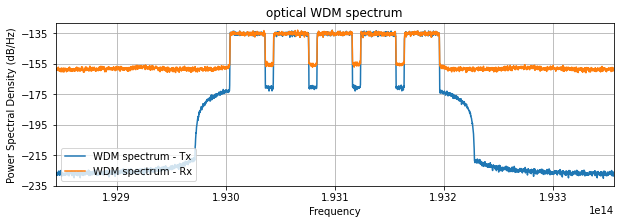

In [9]:
# plot psd
plt.figure()
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM, Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

**WDM channels coherent detection and demodulation**

Demodulating channel #2 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 64.00 MHz




Estimated FO : -64.0000 MHz
Estimated SNR = 16.56 dB 

Total counted bits = 58000  
Total of counted errors = 2090  
BER = 3.60e-02  


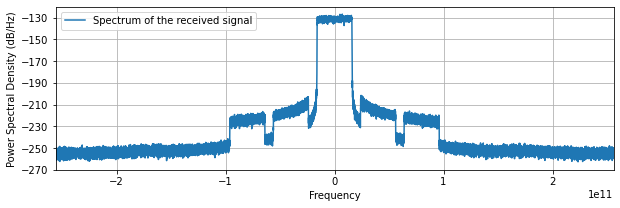

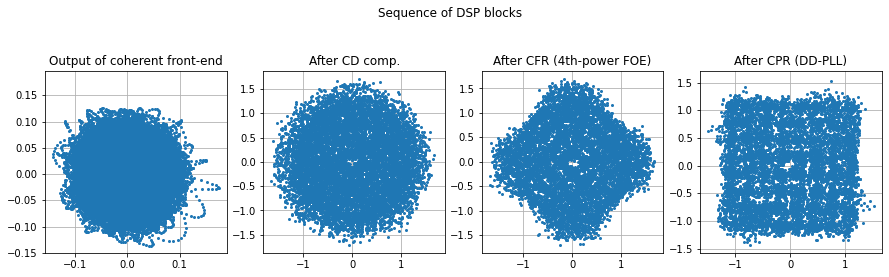

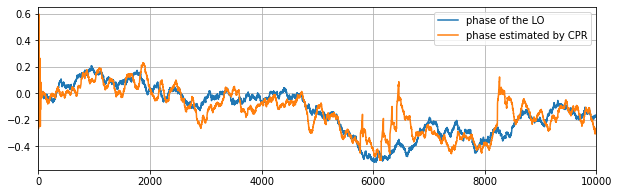

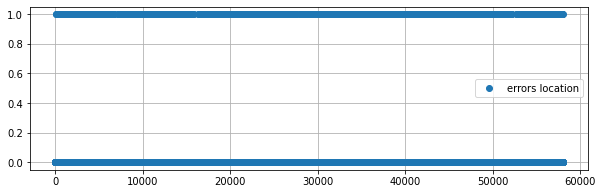

In [18]:
### Receiver

# parameters
chIndex = 2    # index of the channel to be demodulated
plotPSD = True

Fa = param.SpS*param.Rs
Fc = paramCh.Fc
Ta = 1/Fa
mod = QAMModem(m=param.M)

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

sigWDM = sigWDM.reshape(len(sigWDM),)
symbTx = symbTx_[:,:,chIndex].reshape(len(symbTx_),)

# local oscillator (LO) parameters:
FO      = 64e6                 # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 100e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# single-polarization coherent optical receiver
sigRx = coherentReceiver(sigWDM, sigLO)

# Rx filtering

# Matched filter
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)

pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plot psd
if plotPSD:
    plt.figure();
   # plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Spectrum of the received signal')
    plt.legend(loc='upper left');
    plt.xlim(-Fa/2,Fa/2);

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,4.5))
fig.suptitle('Sequence of DSP blocks')

ax1.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax1.axis('square')
ax1.title.set_text('Output of coherent front-end')
ax1.grid()

# digital backpropagation
hzDBP = 5
Pin   = 10**(param.Pch_dBm/10)*1e-3
sigRx = sigRx/np.sqrt(signal_power(sigRx))
sigRx = dbp(np.sqrt(Pin)*sigRx, Fa, paramCh.Ltotal, paramCh.Lspan, hzDBP, paramCh.alpha, paramCh.gamma, paramCh.D, paramCh.Fc)
sigRx = sigRx.reshape(len(sigRx),)
sigRx = firFilter(pulse, sigRx)
    
# CD compensation
# sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fa)

# simple timing recovery
varVector = np.var((sigRx.T).reshape(-1,param.SpS), axis=0) # finds best sampling instant
sampDelay = np.where(varVector == np.amax(varVector))[0][0]

# downsampling
sigRx = sigRx[sampDelay::param.SpS]

discard = 1000
ind = np.arange(discard, sigRx.size-discard)

# symbol normalization
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# plot constellation after CD compensation
ax2.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax2.axis('square')
ax2.title.set_text('After CD comp.')
ax2.grid()

# calculate time delay due to walkoff
symbDelay = np.argmax(signal.correlate(np.abs(symbTx), np.abs(sigRx)))-sigRx.size+1 

# compensate walkoff time delay
sigRx = np.roll(sigRx, symbDelay)

# symbol normalization
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# estimate and compensate LO frequency offset
fo = fourthPowerFOE(sigRx, 1/param.Rs)
print('Estimated FO : %3.4f MHz'%(fo/1e6))

sigRx = sigRx*np.exp(-1j*2*π*fo*np.arange(0,len(sigRx))/param.Rs)

# plot constellation after LO frequency offset compensation
ax3.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax3.axis('square')
ax3.title.set_text('After CFR (4th-power FOE)')
ax3.grid()

# compensate phase noise (carrier phase recovery - cpr)
windowSize = 40
c  = mod.constellation/np.sqrt(mod.Es)
sigRx, ϕ, θ = cpr(sigRx, windowSize, c, symbTx)

# plot phases estimated by cpr
phaseOffSet = np.mean(np.roll(ϕ_pn_lo[::param.SpS], symbDelay)-θ)
plt.figure()
plt.plot(np.roll(ϕ_pn_lo[::param.SpS], symbDelay), label='phase of the LO');
plt.plot(θ+phaseOffSet, label='phase estimated by CPR');
plt.grid()
plt.xlim(0,θ.size)
plt.legend();

# correct (possible) phase ambiguity
rot = np.mean(symbTx[ind]/sigRx[ind])
sigRx  = rot*sigRx

# symbol normalization
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# plot constellation after cpr
ax4.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax4.axis('square')
ax4.title.set_text('After CPR (DD-PLL)')
ax4.grid()

# estimate SNR of the received constellation
SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# hard decision demodulation of the received symbols    
bitsRx = mod.demodulate(np.sqrt(mod.Es)*sigRx, demod_type = 'hard') 
bitsTx = mod.demodulate(np.sqrt(mod.Es)*symbTx, demod_type = 'hard') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('Estimated SNR = %.2f dB \n'%(10*np.log10(SNR)))
print('Total counted bits = %d  '%(err.size))
print('Total of counted errors = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'errors location')
plt.legend()
plt.grid()

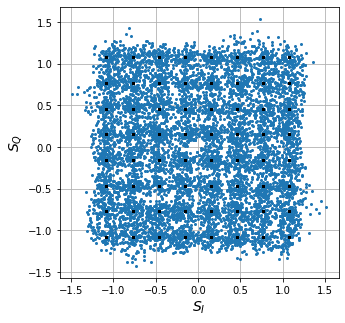

In [19]:
plt.figure(figsize=(5,5))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1.1,1.1)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx');

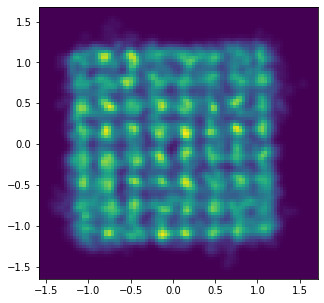

In [20]:
from scipy.stats.kde import gaussian_kde

y = (sigRx[ind]).real
x = (sigRx[ind]).imag

k = gaussian_kde(np.vstack([x, y]))
k.set_bandwidth(bw_method=k.factor/4)

xi, yi = 1.1*np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1, shading='auto');

In [13]:
def powerProfile(Pin, alpha, Lspan, Nspans):
    
    L = np.linspace(0, Nspans*Lspan, 2000)
    
    power = Pin-alpha*(L%Lspan)
    
    plt.plot(L, power,'')
    plt.xlabel('L [km]')
    plt.ylabel('power [dBm]')
    plt.title('Power profile')
    plt.grid()
    plt.xlim(min(L), max(L))

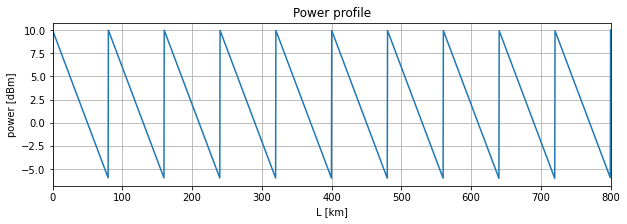

In [14]:
powerProfile(10, 0.2, 80, 10)

## Polarization multiplexed WDM signal

**WDM signal generation**

In [ ]:
# Parâmetros do transmissor:
param = parameters()
param.M   = 16           # ordem do formato de modulação
param.Rs  = 32e9         # taxa de sinalização [baud]
param.SpS = 16           # número de amostras por símbolo
param.Nbits = 60000      # número de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 4096       # número de coeficientes do filtro RRC
param.alphaRRC = 0.01    # rolloff do filtro RRC
param.Pch_dBm = 1        # potência média por canal WDM [dBm]
param.Nch     = 9        # número de canais WDM
param.Fc      = 193.1e12 # frequência central do espectro WDM
param.freqSpac = 40e9    # espaçamento em frequência da grade de canais WDM
param.Nmodes = 2         # número de modos de polarização

sigWDM_Tx, symbTx_, param = simpleWDMTx(param)

freqGrid = param.freqGrid

Mode #0
channel 1 power : -2.01 dBm, fc : 192.9400 THz
channel 2 power : -2.01 dBm, fc : 192.9800 THz


**Nonlinear fiber propagation with the split-step Fourier method**

In [20]:
linearChannel = False

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 800   # km
paramCh.Lspan  = 80    # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.hz = 0.5       # km
paramCh.gamma = 1.3    # 1/(W.km)

if linearChannel:
    paramCh.hz = paramCh.Lspan  # km
    paramCh.gamma = 0   # 1/(W.km)

Fs = param.Rs*param.SpS
sigWDM, paramCh = manakov_ssf(sigWDM_Tx, Fs, paramCh) 


receivedSignal = sigWDM.copy()
transmSymbols  = symbTx_.copy()

**Optical WDM spectrum before and after transmission**

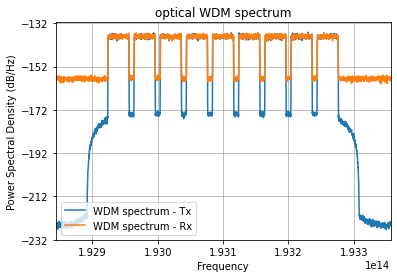

In [21]:
# plot psd
plt.figure()
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

**WDM channels coherent detection and demodulation**

Demodulating channel #4 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 0.00 kHz, FO: 64.00 MHz

Estimated FO : -64.0000 MHz
Estimated SNR = 17.13 dB 

Total counted bits = 58000  
Total of counted errors = 48  
BER = 8.28e-04  


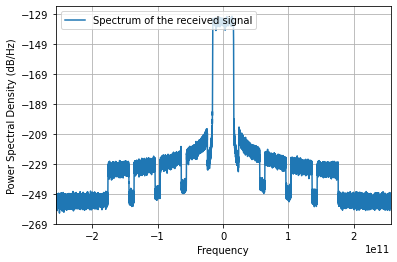

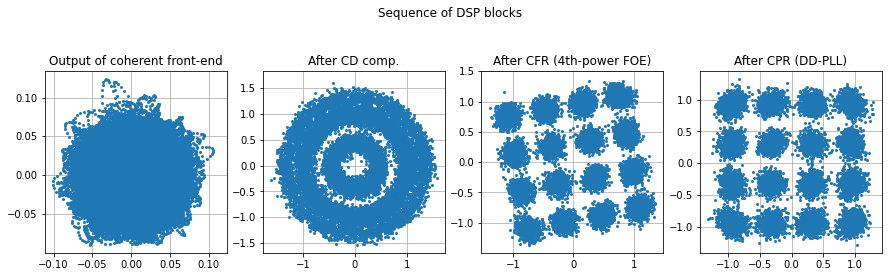

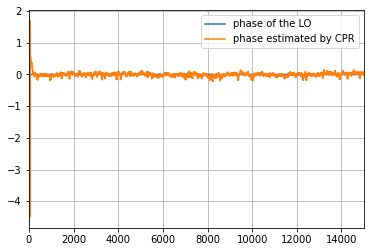

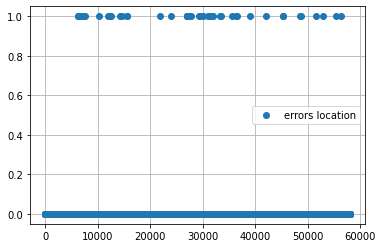

In [23]:
### Receiver

# parameters
chIndex  = 4    # index of the channel to be demodulated
polIndex = 0
plotPSD  = True

Fa = param.SpS*param.Rs
Fc = paramCh.Fc
Ta = 1/Fa
mod = QAMModem(m=param.M)

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

sigWDM = receivedSignal[:,polIndex].reshape(len(sigWDM),)
symbTx = transmSymbols[:,polIndex,chIndex].reshape(len(symbTx_),)

# local oscillator (LO) parameters:
FO      = 64e6                 # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 0*100e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# single-polarization coherent optical receiver
sigRx = coherentReceiver(sigWDM, sigLO)

# Rx filtering

# Matched filter
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)

pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plot psd
if plotPSD:
    plt.figure();
   # plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Spectrum of the received signal')
    plt.legend(loc='upper left');
    plt.xlim(-Fa/2,Fa/2);

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,4.5))
fig.suptitle('Sequence of DSP blocks')

ax1.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax1.axis('square')
ax1.title.set_text('Output of coherent front-end')
ax1.grid()

# digital backpropagation
# hzDBP = 5
# Pin   = 10**(param.Pch_dBm/10)*1e-3
# sigRx = sigRx/np.sqrt(signal_power(sigRx))
# sigRx = dbp(np.sqrt(Pin)*sigRx, Fa, paramCh.Ltotal, paramCh.Lspan, hzDBP, paramCh.alpha, paramCh.gamma, paramCh.D, paramCh.Fc)
# sigRx = sigRx.reshape(len(sigRx),)
# sigRx = firFilter(pulse, sigRx)
    
# CD compensation
sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fa)

# simple timing recovery
varVector = np.var((sigRx.T).reshape(-1,param.SpS), axis=0) # finds best sampling instant
sampDelay = np.where(varVector == np.amax(varVector))[0][0]

# downsampling
sigRx = sigRx[sampDelay::param.SpS]

discard = 1000
ind = np.arange(discard, sigRx.size-discard)

# symbol normalization
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# plot constellation after CD compensation
ax2.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax2.axis('square')
ax2.title.set_text('After CD comp.')
ax2.grid()

# calculate time delay due to walkoff
symbDelay = np.argmax(signal.correlate(np.abs(symbTx), np.abs(sigRx)))-sigRx.size+1 

# compensate walkoff time delay
sigRx = np.roll(sigRx, symbDelay)

# symbol normalization
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# estimate and compensate LO frequency offset
fo = fourthPowerFOE(sigRx, 1/param.Rs)
print('Estimated FO : %3.4f MHz'%(fo/1e6))

sigRx = sigRx*np.exp(-1j*2*π*fo*np.arange(0,len(sigRx))/param.Rs)

# plot constellation after LO frequency offset compensation
ax3.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax3.axis('square')
ax3.title.set_text('After CFR (4th-power FOE)')
ax3.grid()

# compensate phase noise (carrier phase recovery - cpr)
windowSize = 40
c  = mod.constellation/np.sqrt(mod.Es)
sigRx, ϕ, θ = cpr(sigRx, windowSize, c, symbTx)

# plot phases estimated by cpr
phaseOffSet = np.mean(np.roll(ϕ_pn_lo[::param.SpS], symbDelay)-θ)
plt.figure()
plt.plot(np.roll(ϕ_pn_lo[::param.SpS], symbDelay), label='phase of the LO');
plt.plot(θ+phaseOffSet, label='phase estimated by CPR');
plt.grid()
plt.xlim(0,θ.size)
plt.legend();

# correct (possible) phase ambiguity
rot = np.mean(symbTx[ind]/sigRx[ind])
sigRx  = rot*sigRx

# symbol normalization
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# plot constellation after cpr
ax4.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax4.axis('square')
ax4.title.set_text('After CPR (DD-PLL)')
ax4.grid()

# estimate SNR of the received constellation
SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# hard decision demodulation of the received symbols    
bitsRx = mod.demodulate(np.sqrt(mod.Es)*sigRx, demod_type = 'hard') 
bitsTx = mod.demodulate(np.sqrt(mod.Es)*symbTx, demod_type = 'hard') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('Estimated SNR = %.2f dB \n'%(10*np.log10(SNR)))
print('Total counted bits = %d  '%(err.size))
print('Total of counted errors = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'errors location')
plt.legend()
plt.grid()